In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sagyamthapa/handwritten-math-symbols")

print("Path to dataset files:", path)

100%|██████████| 39.4M/39.4M [00:00<00:00, 64.7MB/s]


Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/sagyamthapa/handwritten-math-symbols/versions/4


In [ ]:
import os
import shutil
import random

import torch
import torch.nn as nn
from torchvision.transforms.functional import to_pil_image
from torchvision import  transforms
from torchvision import datasets
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

In [ ]:
print(os.listdir('/root/.cache/kagglehub/datasets/sagyamthapa/handwritten-math-symbols/versions/4/dataset'))
os.rename('/root/.cache/kagglehub/datasets/sagyamthapa/handwritten-math-symbols/versions/4/dataset', 'dataset_unorganized')

['mul', '6', 'eq', 'x', 'dec', '8', 'y', 'sub', '3', '4', '5', '7', '2', 'add', '.directory', '9', '0', 'z', '1', 'div']


In [ ]:
print(os.listdir('dataset_unorganized'))
os.rename('dataset_unorganized/add', 'dataset_unorganized/+')
os.rename('dataset_unorganized/sub', 'dataset_unorganized/-')
print(os.listdir('dataset_unorganized'))

['mul', '6', 'eq', 'x', 'dec', '8', 'y', 'sub', '3', '4', '5', '7', '2', 'add', '.directory', '9', '0', 'z', '1', 'div']
['mul', '6', 'eq', 'x', 'dec', '8', 'y', '3', '4', '5', '7', '2', '.directory', '9', '+', '-', '0', 'z', '1', 'div']


Train data:
Dataset ImageFolder
    Number of datapoints: 29575
    Root location: ./dataset_organized/train
    StandardTransform
Transform: Compose(
               Resize(size=(180, 180), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

Validation data:
Dataset ImageFolder
    Number of datapoints: 12676
    Root location: ./dataset_organized/validation
    StandardTransform
Transform: Compose(
               Resize(size=(180, 180), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )


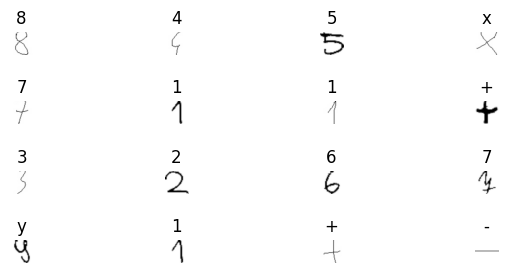

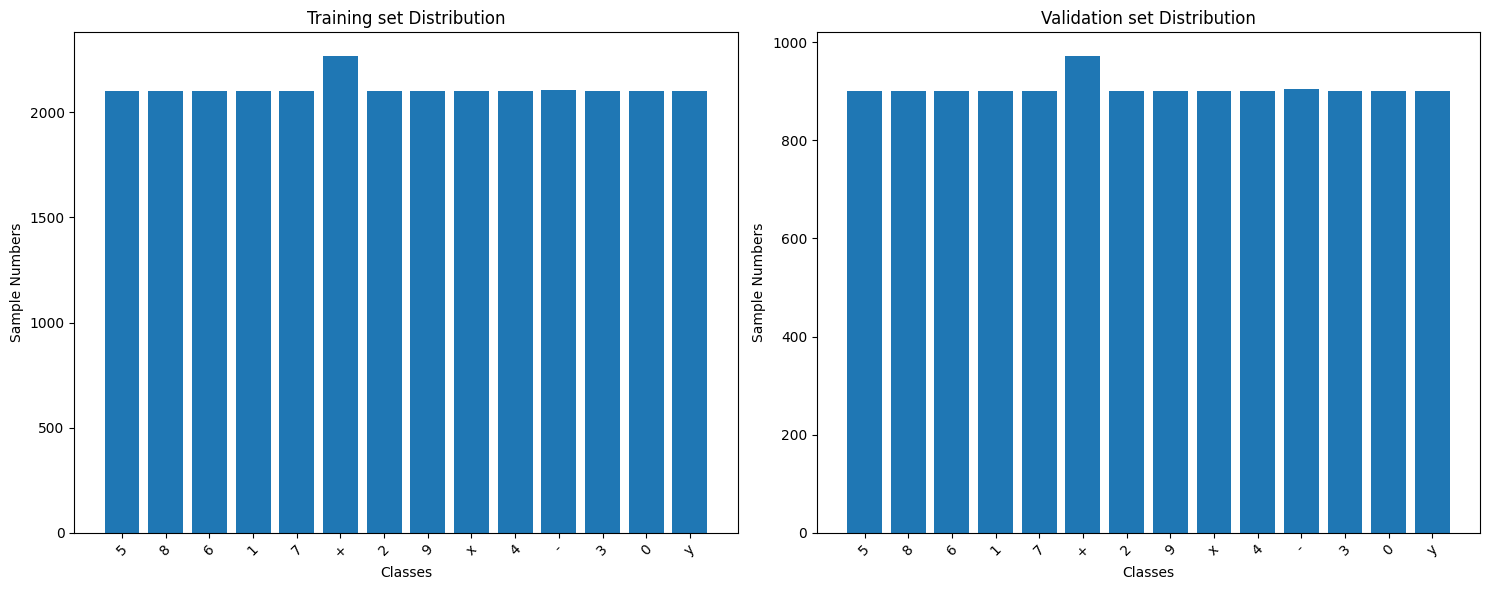

In [ ]:
# original path
original_dataset_dir ="./dataset_unorganized/" # folder that contains all images

# new paths for training and validation sets
base_dir = "./dataset_organized"   # new folder for your train and validation folders
if not os.path.exists(base_dir):
        os.makedirs(base_dir)

# new folder for training set
train_dir = os.path.join(base_dir, 'train')
if not os.path.exists(train_dir):
        os.makedirs(train_dir)

# new folder for validation set
validation_dir = os.path.join(base_dir, 'validation')
if not os.path.exists(validation_dir):
        os.makedirs(validation_dir)

classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'x', 'y', '+', '-']  # class names

for cls in classes:
    cls_dir = os.path.join(original_dataset_dir, cls)
    files = os.listdir(cls_dir)
    random.shuffle(files)

    # split dataset to training and validation
    split_point = int(0.7 * len(files))   # training percentage is 0.7 --> %70
    train_files = files[:split_point]
    validation_files = files[split_point:]

    train_cls_dir = os.path.join(train_dir, cls)
    if not os.path.exists(train_cls_dir):
        os.makedirs(train_cls_dir)

    validation_cls_dir = os.path.join(validation_dir, cls)
    if not os.path.exists(validation_cls_dir):
        os.makedirs(validation_cls_dir)

    # copy files to the folders
    for file in train_files:
        src = os.path.join(cls_dir, file)
        dst = os.path.join(train_cls_dir, file)
        shutil.copyfile(src, dst)

    for file in validation_files:
        src = os.path.join(cls_dir, file)
        dst = os.path.join(validation_cls_dir, file)
        shutil.copyfile(src, dst)


train_transform  = transforms.Compose([
    # Resize Image
    transforms.Resize(size=(180, 180)),
    # Turn the image into a torch.Tensor , it transforms the image to a tensor with range [0,1]. I t implies some kind of normalization
    transforms.ToTensor()
])

validation_transform  = transforms.Compose([
    transforms.Resize(size=(180, 180)),
    transforms.ToTensor()
])

# Use ImageFolder to create datasets
train_data = datasets.ImageFolder(root=train_dir, transform=train_transform)
validation_data = datasets.ImageFolder(root=validation_dir, transform=validation_transform)

print(f"Train data:\n{train_data}\n\nValidation data:\n{validation_data}")


# I created  train_data and validation_data with datasets.ImageFolder
train_set = DataLoader(dataset=train_data,
                        batch_size=16, # how many samples per batch?
                        num_workers=2, # how many subprocesses to use for data loading? (higher = more)
                        shuffle=True) # shuffle the data?

validation_set = DataLoader(dataset=validation_data,
                        batch_size=16,
                        num_workers=2,
                        shuffle=False) # dont usually need to shuffle testing data



# I create train_data above , and I will use it here
label_dict = {y: x for x, y in train_data.class_to_idx.items()}

# Define a function to display images
def show_images(_images, _labels):
    plt.figure(figsize=(7, 3))
    for i in range(len(_images)):
      if i < 16:
        plt.subplot(4, 4, i + 1)
        image = to_pil_image(_images[i])  # Convert tensor to PIL Image
        plt.imshow(image)
        plt.title(label_dict[_labels[i].item()])  # Convert numerical label to string label
        plt.axis('off')
      else:
        break

    plt.subplots_adjust(wspace=1, hspace=2)
    plt.show()

# Get the first batch
for batch_idx, (images, labels) in enumerate(train_set):
    if batch_idx == 0:  # Only process the first batch
        show_images(images, labels)
        break

# calculate distributions in train set and save them to dictionary
train_class_counts = {}
for class_folder in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_folder)
    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        train_class_counts[class_folder] = num_images

# calculate distributions in validation set and save them to dictionary
validation_class_counts = {}
for class_folder in os.listdir(validation_dir):
    class_path = os.path.join(validation_dir, class_folder)
    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        validation_class_counts[class_folder] = num_images


plt.figure(figsize=(15, 6))

# plot for train set
plt.subplot(1, 2, 1)
plt.bar(train_class_counts.keys(), train_class_counts.values())
plt.title('Training set Distribution')
plt.xlabel('Classes')
plt.ylabel('Sample Numbers')
plt.xticks(rotation=45)

# plot for validations set
plt.subplot(1, 2, 2)
plt.bar(validation_class_counts.keys(), validation_class_counts.values())
plt.title('Validation set Distribution')
plt.xlabel('Classes')
plt.ylabel('Sample Numbers')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()



train_accuracies=[]
validation_accuracies=[]

# Function for training
def train(dataloader, _model, _loss_fn, _optimizer, epoch):

    size = len(dataloader.dataset) # total number of images inside of loader
    num_batches = len(dataloader) # number of batches

    _model.train()

    train_loss, correct = 0, 0

    for batch, (x, y) in enumerate(dataloader):
        # move X and y to GPU for faster training
        x, y = x.to(device), y.to(device)

        pred = _model(x) # make prediction
        loss = _loss_fn(pred, y) # calculate loss

        # Backpropagation
        loss.backward() # compute parameters gradients
        _optimizer.step() # update parameters
        _optimizer.zero_grad() #  reset the gradients of all parameters

        # Update training loss
        train_loss += loss.item() # item() method extracts the loss’s value as a Python float

        # Calculate training accuracy
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    # loss and accuracy
    train_loss = train_loss / num_batches
    accuracy = 100 * correct / size

    # use this accuracy list for plotting accuracy with matplotlib
    train_accuracies.append(accuracy)

    # Print training accuracy and loss at the end of epoch
    print(f" Training Accuracy: {accuracy:.2f}%, Training Loss: {train_loss:.4f}")

# function for validation
def validation(dataloader, _model, _loss_fn, t):

    size = len(dataloader.dataset) # total number of images inside of loader
    num_batches = len(dataloader) # number of batches

    validation_loss, correct = 0, 0

    # sets the PyTorch model to evaluation mode, it will disable dropout layer
    _model.eval()

    with torch.no_grad(): #  disable gradient calculation
        for x, y in dataloader:

            # move X and y to GPU for faster training
            x, y = x.to(device), y.to(device)
            pred = _model(x) # make prediction
            validation_loss += _loss_fn(pred, y).item()

            # if prediction is correct add 1 to correct variable.
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    # loss and accuracy
    validation_loss /= num_batches
    accuracy = 100 * correct / size

    validation_accuracies.append(accuracy)

    # Print test accuracy and loss at the end of epoch
    print(f" Validation Accuracy: {accuracy:.2f}%, Validation Loss: {validation_loss:.4f}")



In [ ]:
# if GPU is available , use it while training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=14):
        super(SimpleCNN, self).__init__()

        # image size is --> (3,180,180)

        # convolutional layer with 32 filter ,input dimension is 3 because image has 3 channels
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        # activation function , it adds   introduces non-linearity to the model , thus  it helps to model to learn complex functions .
        self.act1 = nn.ReLU()
        # it reduces pixel number  (90,90)
        self.pool1 = nn.MaxPool2d(2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)  # --> (45,45)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.act3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2) # --> (22,22)

        # first flatten the channels and then feed them into the fully connected layer. Given the input shape of (128, 22, 22), flattening it results in 128 * 22 * 22.
        self.fc1 = nn.Linear(128 * 22 * 22 , 256)
        self.act4 = nn.ReLU()

        # dropout drops randomly neurons , here %20 of neurons are dropped randomly . It helps to prevent overfitting
        self.dropout=nn.Dropout(p=0.2)

        # The nn.Linear layer with input size 256 and output size 9 represents the output layer of our neural network.
        # Since we have 9 classes, the output of this layer will be passed through a softmax activation function.
        # (error function  internally applies softmax activation ,you dont need to add it to here)
        # This converts the raw outputs into probabilities, representing the likelihood of each class.
        # These probabilities are then used to calculate the error during trainin
        self.fc2 = nn.Linear(256, num_classes)


    def forward(self, x):

        # add outputs on top of each layer and return out in the end
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = self.pool3(self.act3(self.conv3(out)))

        out = out.view(out.size(0), -1)

        out = self.act4(self.fc1(out))
        out=self.dropout(out)
        out=self.fc2(out)

        return out

# create model
model = SimpleCNN()

model.to(device)
print(model)

Using cuda device
SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=61952, out_features=256, bias=True)
  (act4): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=256, out_features=14, bias=True)
)


In [ ]:
# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
# epoch number
epochs = 20

# loop for training model
for t in range(epochs):
    print(f"Epoch {t+1}")
    train(train_set, model, loss_fn, optimizer,t)
    validation(validation_set, model, loss_fn,t)
    print("----------------------------")
print("Done!")

Epoch 1
 Training Accuracy: 10.10%, Training Loss: 2.6290
 Validation Accuracy: 15.89%, Validation Loss: 2.6038
----------------------------
Epoch 2
 Training Accuracy: 24.50%, Training Loss: 2.3457
 Validation Accuracy: 43.37%, Validation Loss: 1.8627
----------------------------
Epoch 3
 Training Accuracy: 51.11%, Training Loss: 1.5049
 Validation Accuracy: 67.41%, Validation Loss: 1.0371
----------------------------
Epoch 4
 Training Accuracy: 77.56%, Training Loss: 0.7613
 Validation Accuracy: 84.74%, Validation Loss: 0.5521
----------------------------
Epoch 5
 Training Accuracy: 85.46%, Training Loss: 0.5076
 Validation Accuracy: 89.40%, Validation Loss: 0.3866
----------------------------
Epoch 6
 Training Accuracy: 89.33%, Training Loss: 0.3801
 Validation Accuracy: 91.50%, Validation Loss: 0.3059
----------------------------
Epoch 7
 Training Accuracy: 91.91%, Training Loss: 0.2882
 Validation Accuracy: 93.07%, Validation Loss: 0.2482
----------------------------
Epoch 8
 Trai

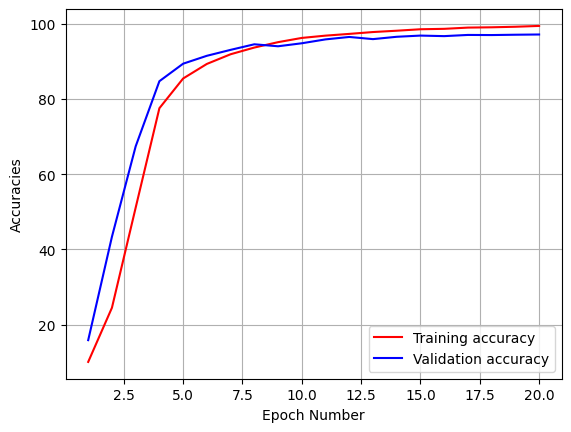

In [ ]:
def visualize(_train_accuracies, _validation_accuracies):
    epoch_number=len(_train_accuracies)

    plt.plot(range(1,epoch_number+1), _train_accuracies, 'r', label='Training accuracy')
    plt.plot(range(1,epoch_number+1), _validation_accuracies, 'b', label='Validation accuracy')
    plt.legend()
    plt.xlabel("Epoch Number")
    plt.ylabel("Accuracies")
    plt.grid()

# Remember , this 2 parameters are lists , I created them above and append values to them regularly
visualize(train_accuracies,validation_accuracies)

# save the model
torch.save(model.state_dict(), "./model.pth")
# save the class names in a dict
class_names = train_data.classes
torch.save(class_names, "./class_names.pth")